In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import math 

# 1. Introduction
This is a Machine Learning application to try to predict if a given passenger of the Titanic survived. This is also my first Kaggle competition!

## 2. The dataset
First thing we are going to do is analyse the dataset. To do so, we are going to use the pandas library.

In [3]:
df = pd.read_csv("train.csv")
display(df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Note here that some columns are useless for the analysis, such as the names of each person, and others are not numerical, which will have to be transformed.

## 2.1. Transforming the Dataset
I will use a Multivariate Logistic Regression to analyse this problem. To to so, I will implement the cost function and gradient descent from scratch. To do so, I will make some conventions:
* The names of each passenger and their ticket numbers will not be considered on the analysis;
* Sex will be encoded as follows: Sex = 1 if passenger is a male; Sex = 0 if passenger is a female;
* Embarked will be be encoded as follows: Embarked = 0 if C, 1 if Q and 2 if S;
* The cabins will be encoded as two different elements, one for the letter (CabinY) and one for the numbers (CabinX) in it.
  

In [4]:
def TransformDF(df):
    # Transform the values in each column:
    df['Sex'] = df['Sex'].map({'male' : 1, 'female' : 0})
    df['Embarked'] = df['Embarked'].map({'C' : 0, 'Q' : 1, 'S' : 2})
    
    # Take the letters and numbers in each cabin and transform it:
    df['CabinY'] = df['Cabin'].str.extract(r'([A-Za-z]+)')  
    df['CabinX'] = df['Cabin'].str.extract(r'(\d+)') 
    df['CabinY'] = df['CabinY'].map({'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3, 'E' : 4, 'F' : 5, 'G' : 6})
    
    # Fill the NaN in the columns with the average as an estimator for them:
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mean())
    df['Age'] = df['Age'].fillna(df['Age'].mean()) 
    df['CabinX'] = df['CabinX'].fillna(0).astype(int)
    df['CabinX'] = df['CabinX'].apply(lambda x : x if x != 0 else df['CabinX'].mean())
    df['CabinY'] = df['CabinY'].fillna(df['CabinY'].mean()).astype(int)
    

Now that the DataFrame is ready, I will make a function that returns the input and target vectors given the DataFrame.

In [5]:
def MakeDataset(df):
    df_filtered_X = df.drop(['Name', 'PassengerId', 'Ticket', 'Survived', 'Cabin'], axis=1)
    X_training = df_filtered_X.to_numpy()
    Y_training = df['Survived'].to_numpy().reshape(-1)
    
    return X_training, Y_training

In [6]:
TransformDF(df)
X_train, Y_train = MakeDataset(df)
print(X_train.shape)
print(Y_train.shape)

(891, 9)
(891,)


## 3. The Algorithm
I will now begin building the Logistic Regression algorithm. This algorithm will be based off of the cost function 
$$ J(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] \tag{1}$$
with

$$ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \tag{2} $$

and 
$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = sigmoid(z_{\mathbf{w},b}(\mathbf{x}^{(i)})) $


In [7]:
def sigmoid(z) :
    return 1 / (1 + np.exp(-z))
def compute_cost(X, y, w, b, lambda_):
    m, n = X.shape
    z = np.dot(X, w) + b
    f = sigmoid(z)
    cost = (-y * np.log(f) - (1 - y) * np.log(1 - f)).mean()
    # Add regularization to cost function
    cost += (lambda_ / (2 * m)) * np.sum(np.square(w))
    return cost

Now I will program the gradient descent: $$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & b := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \newline       \; & w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1}\newline & \rbrace\end{align*}$$

In [8]:
def compute_gradient(X, y, w, b, lambda_):
    m, n = X.shape
    z = np.dot(X, w) + b
    f = sigmoid(z)
    dj_db = (f - y).mean()
    dj_dw = np.dot(X.T, (f - y)) / m
    # Regularization for the weights
    dj_dw += (lambda_ / m) * w
    return dj_db, dj_dw


def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_):
    m = len(X)
    J_history = []
    w_history = []
    
    w = w_in
    b = b_in
    
    for i in range(num_iters):
        dj_db, dj_dw = gradient_function(X, y, w, b, lambda_)
        w -= alpha * dj_dw
        b -= alpha * dj_db
        cost = cost_function(X, y, w, b, lambda_)
        J_history.append(cost)
        
        if i % (num_iters // 10) == 0 or i == num_iters - 1:
            w_history.append(w)
            print(f"Iteration {i}: Cost {cost:.4f}")
    
    return w, b, J_history, w_history

## 4. Training the model
Let us now train the model.

In [9]:
np.random.seed(1)
initial_w = 0.01 * (np.random.rand(X_train.shape[1]) - 0.5)
initial_b = -8

# Some gradient descent settings
iterations = 10000
alpha = 0.001
lambda_ = 0.01
w,b, J_history,_ = gradient_descent(X_train ,Y_train, initial_w, initial_b, 
                                   compute_cost, compute_gradient, alpha, iterations, lambda_)



Iteration 0: Cost 2.6529
Iteration 1000: Cost 1.0044
Iteration 2000: Cost 0.8772


C:\Users\Pc\AppData\Local\Temp\ipykernel_23064\725365770.py:7: RuntimeWarning: divide by zero encountered in log
  cost = (-y * np.log(f) - (1 - y) * np.log(1 - f)).mean()
C:\Users\Pc\AppData\Local\Temp\ipykernel_23064\725365770.py:7: RuntimeWarning: invalid value encountered in multiply
  cost = (-y * np.log(f) - (1 - y) * np.log(1 - f)).mean()


Iteration 3000: Cost 0.8082
Iteration 4000: Cost 0.7731
Iteration 5000: Cost 0.7531
Iteration 6000: Cost 0.7393
Iteration 7000: Cost 0.7285
Iteration 8000: Cost 0.7193
Iteration 9000: Cost 0.7114
Iteration 9999: Cost 0.7043


In [10]:
def predict(X, w, b, threshold): 
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w
    
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      w : (ndarray Shape (n,))  values of parameters of the model      
      b : (scalar)              value of bias parameter of the model

    Returns:
      p : (ndarray (m,)) The predictions for X using a threshold at 0.5
    """
    # number of training examples
    m, n = X.shape   
    p = np.zeros(m)
   
    ### START CODE HERE ### 
    # Loop over each example
    for i in range(m):   
        z_wb = 0
        # Loop over each feature
        for j in range(n): 
            # Add the corresponding term to z_wb
            z_wb += w[j] * X[i][j]
        
        # Add bias term 
        z_wb += b
        
        # Calculate the prediction for this example
        f_wb = sigmoid(z_wb)

        # Apply the threshold
        p[i] = f_wb >= threshold
        
    ### END CODE HERE ### 
    return p.astype(int)






## 5. Testing 

In [11]:
def MakeTestDataset(df):
    df_filtered_X = df.drop(['Name', 'PassengerId', 'Ticket', 'Cabin'], axis=1)
    X_training = df_filtered_X.to_numpy()
    
    return X_training

In [12]:
def getRecall(X, Y, y_hat):
    # P(y_hat = 1 | Y = 1)
    return ((Y == 1) & (y_hat == 1)).astype(int).sum() / (((Y == 1) & (y_hat == 0)).astype(int).sum() + ((Y == 1) & (y_hat == 1)).astype(int).sum()) 
def getPrecision(X, Y, y_hat) : 
    # P(Y = 1 | y_hat = 1)
    return ((Y == 1) & (y_hat == 1)).astype(int).sum() / (((Y == 0) & (y_hat == 1)).astype(int).sum() + ((Y == 1) & (y_hat == 1)).astype(int).sum()) 
def getF1Score(X, Y, y_hat) :
    return 2/((1/getPrecision(X, Y, y_hat)) + (1/getRecall(X, Y, y_hat)))
    

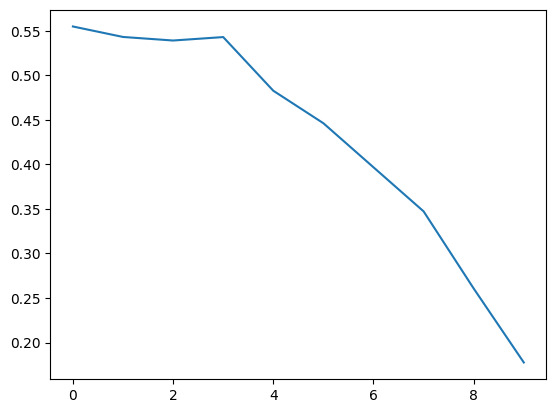

In [13]:
df_test = pd.read_csv('test.csv') 
TransformDF(df_test)
X_test = MakeTestDataset(df_test)
F1_history = []
for i in range(0, 10):
    y_hat = predict(X_train, w, b, i/10)
    F1_history.append(getF1Score(X_train, Y_train, y_hat))
plt.plot(range(0, 10), F1_history)
plt.show()

threshold = 0.3

Notice that the optimal range for the threshold to maximize the F1 score is from 0.1 to 0.3. We will hereby choose threshold = 0.3.

## 6. Decision Tree Comparison
Now, let's compare that performance to a decision tree. To do so, I will use XGBoost trees to do so.

In [14]:
import xgboost as xgb
import sklearn

modelTree = xgb.XGBClassifier()
modelTree.fit(X_train, Y_train)
y_hat_Tree = modelTree.predict(X_train)
print(getF1Score(X_train, Y_train, y_hat_Tree))
print(getPrecision(X_train, Y_train, y_hat_Tree))
print(getRecall(X_train, Y_train, y_hat_Tree))

0.9580838323353292
0.9815950920245399
0.935672514619883


Notice that the F1 score is way higher with this method. This may be due to the fact that decision trees are better suited for problems that do not have much data and where the relation of each feature with the output is not necessarily linear. Hereby, I will use the Decision Tree prediction as the final answer.

## 7. Sending out the results

In [15]:

y_hat_Tree = modelTree.predict(X_test)
dfResults = pd.DataFrame({
    'PassengerId' : df_test['PassengerId'],
    'Survived' : y_hat_Tree
}, )
display(dfResults)
dfResults.to_csv('submission.csv', index=False)
print("The submission was successfully saved!")


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


The submission was successfully saved!
